# Semi Supervised Learning - Co-Training Model

This notebook is to perform semi-supervised learning by using the co-training algorithm from the baseline model. The baseline model is developed in `CSI5155 Project - baseline.ipynb`. We only consider the training set in this notebook.

## Import Necessary Packages

In [1]:
import numpy as np;
import os;
import sys;
import joblib;
import random;
from sklearn.model_selection import train_test_split;
# importing custom modules
sys.path.append("../Assignment 1 - Model Comparison/");
from fileOrganizer import unpack;
from performance import evalAccuracy, evalPrecision, evalRecall, evalF1Score, printConfMtx, plotROC;
import constants;

## Load the Data

In [2]:
X_train_labelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.X_TRAIN_LABELLED_FILENAME
));
print("Number of Labelled Samples: ", len(X_train_labelled));
print("Number of Features in the Labelled Training Set: ", len(X_train_labelled[random.randint(0, len(X_train_labelled)-1)]));
print("Value range of the Labelled Training Set: ", np.min(X_train_labelled), np.max(X_train_labelled));

Number of Labelled Samples:  251
Number of Features in the Labelled Training Set:  12
Value range of the Labelled Training Set:  -4.827248760778992 3.262658784576777


In [3]:
y_train_labelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.Y_TRAIN_LABELLED_FILENAME
));
print("Number of Labelled Labels: ", len(y_train_labelled));
print("Unique Labels: ", np.unique(y_train_labelled));

Number of Labelled Labels:  251
Unique Labels:  [0 1]


In [4]:
X_train_unlabelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.X_TRAIN_UNLABELLED_FILENAME
));
print("Number of Unlabelled Samples: ", len(X_train_unlabelled));
print("Number of Features in the Unlabelled Training Set: ", len(X_train_unlabelled[random.randint(0, len(X_train_unlabelled)-1)]));
print("Value range of the Unlabelled Training Set: ", np.min(X_train_unlabelled), np.max(X_train_unlabelled));

Number of Unlabelled Samples:  1005
Number of Features in the Unlabelled Training Set:  12
Value range of the Unlabelled Training Set:  -4.827248760778992 13.457018899436779


In [5]:
# This is the true labels for the supposedly unlabelled data
# for debugging purpose!!!
y_train_unlabelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.Y_TRAIN_UNLABELLED_FILENAME
));
print("Number of Unlabelled Labels: ", len(y_train_unlabelled));
print("Unique Labels: ", np.unique(y_train_unlabelled));

Number of Unlabelled Labels:  1005
Unique Labels:  [0 1]


In [6]:
X_test = unpack(os.path.join(
    constants.TEST_DIR,
    constants.X_TEST_NORMALIZED_FILENAME
));
print("Number of Test Samples: ", len(X_test));
print("Number of Features in the Test Set: ", len(X_test[random.randint(0, len(X_test)-1)]));
print("Value range of the Test Set: ", np.min(X_test), np.max(X_test));

Number of Test Samples:  629
Number of Features in the Test Set:  12
Value range of the Test Set:  -4.827248760778992 13.457018899436779


In [7]:
y_test = unpack(os.path.join(
    constants.TEST_DIR,
    constants.Y_TEST_NORMALIZED_FILENAME
));
print("Number of Test Labels: ", len(y_test));
print("Unique Labels in Test Set: ", np.unique(y_test));

Number of Test Labels:  629
Unique Labels in Test Set:  [0 1]


## Load the Column Names

In [8]:
columns = joblib.load(os.path.join(
    constants.COLUMNS_DIR,
    constants.COLUMNS_FILENAME
));
print("Columns in a sample: ", columns);

Columns in a sample:  ['age' 'gender' 'education' 'country' 'ethnicity' 'nscore' 'escore'
 'oscore' 'ascore' 'cscore' 'impuslive' 'ss']


## Load the Model

Note: We already trained the Gradient Boosting classifier with the labelled data in this notebook `CSI5155 Project - baseline.ipynb`. We load 2 models to perform co-training on a subset of features in the data in each classifier.

In [9]:
model1 = unpack(os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_FILENAME
));
model1

RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': array([ 6,  8,  4, 14, 12,  9,  9,  3,  7, 17, 19,  1, 19, 17, 15, 12, 16,
       18,  2,  8, 15,  9, 12,  2,  8, 17, 11,  1, 14, 15, 13,  4,  1, 19,
       12, 15,  6, 19,  9, 17, 10, 12, 16,  3,  5, 13, 10, 19,  5,  5,  4,
       10,  6,  4,  5,  2, 17,  1,  1,  5, 10,  1, 10, 11,  8, 14, 13, 12,
        8, 17, 14,  1,  3,  4, 19, 10,  6, 19, 14,  2, 19, 15, 13,  7,  5,
        3,  4,  3, 14, 10,  5, 16, 10,  5, 16, 15,  4,  8, 17,  8],
      dtype=int64),
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000242FE3ADE70>},
                   random_state=42)

In [10]:
model2 = unpack(os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_FILENAME
));
model2

RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': array([ 6,  8,  4, 14, 12,  9,  9,  3,  7, 17, 19,  1, 19, 17, 15, 12, 16,
       18,  2,  8, 15,  9, 12,  2,  8, 17, 11,  1, 14, 15, 13,  4,  1, 19,
       12, 15,  6, 19,  9, 17, 10, 12, 16,  3,  5, 13, 10, 19,  5,  5,  4,
       10,  6,  4,  5,  2, 17,  1,  1,  5, 10,  1, 10, 11,  8, 14, 13, 12,
        8, 17, 14,  1,  3,  4, 19, 10,  6, 19, 14,  2, 19, 15, 13,  7,  5,
        3,  4,  3, 14, 10,  5, 16, 10,  5, 16, 15,  4,  8, 17,  8],
      dtype=int64),
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000242B0263D90>},
                   random_state=42)

## Co-Training Algorithm

We now intend to train 2 classifiers so that they iteratively label each other's
unlabeled instances

### Data Preparation

In [11]:
featuresInClassifier = round(X_train_unlabelled.shape[1] * constants.CO_TRAINING_FEATURE_SPLIT)

In [12]:
X_train_labelled_1 = X_train_labelled[:, :featuresInClassifier];
X_train_labelled_2 = X_train_labelled[:, featuresInClassifier:];
print("Number of Samples in Classifier 1: ", len(X_train_labelled_1));
print("Number of Samples in Classifier 2: ", len(X_train_labelled_2));
print("Number of Features in the first Labelled Training Set: ", len(X_train_labelled_1[random.randint(0, len(X_train_labelled_1)-1)]));
print("Number of Features in the second Labelled Training Set: ", len(X_train_labelled_2[random.randint(0, len(X_train_labelled_2)-1)]));

Number of Samples in Classifier 1:  251
Number of Samples in Classifier 2:  251
Number of Features in the first Labelled Training Set:  6
Number of Features in the second Labelled Training Set:  6


In [13]:
X_train_unlabelled_1 = X_train_unlabelled[:,:featuresInClassifier];
X_train_unlabelled_2 = X_train_unlabelled[:,featuresInClassifier:];
print("Number of Unlabelled Samples in the first set: ", len(X_train_unlabelled_1));
print("Number of Unlabelled Samples in the second set: ", len(X_train_unlabelled_2));
print("Number of Features in the first Unlabelled Training Set: ", len(X_train_unlabelled_1[random.randint(0, len(X_train_unlabelled_1)-1)]));
print("Number of Features in the second Unlabelled Training Set: ", len(X_train_unlabelled_2[random.randint(0, len(X_train_unlabelled_2)-1)]));

Number of Unlabelled Samples in the first set:  1005
Number of Unlabelled Samples in the second set:  1005
Number of Features in the first Unlabelled Training Set:  6
Number of Features in the second Unlabelled Training Set:  6


In [14]:
X_test_1 = X_test[:, :featuresInClassifier];
X_test_2 = X_test[:, featuresInClassifier:];
print("Number of Test Samples in the first set: ", len(X_test_1));
print("Number of Test Samples in the second set: ", len(X_test_2));
print("Number of Features in the first Test Set: ", len(X_test_1[random.randint(0, len(X_test_1)-1)]));
print("Number of Features in the second Test Set: ", len(X_test_2[random.randint(0, len(X_test_2)-1)]));

Number of Test Samples in the first set:  629
Number of Test Samples in the second set:  629
Number of Features in the first Test Set:  6
Number of Features in the second Test Set:  6


In [15]:
print("Columns in a sample for training the 1st classifier: ", columns[:featuresInClassifier]);
print("Columns in a sample for training the 2nd classifier: ", columns[featuresInClassifier:]);

Columns in a sample for training the 1st classifier:  ['age' 'gender' 'education' 'country' 'ethnicity' 'nscore']
Columns in a sample for training the 2nd classifier:  ['escore' 'oscore' 'ascore' 'cscore' 'impuslive' 'ss']


## Train the Replicated Models

In [16]:
model1.fit(X_train_labelled_1, y_train_labelled);

In [17]:
model2.fit(X_train_labelled_2, y_train_labelled);

### Generate the Pseudo-Labels for Unlabelled Data from Predictions

In [18]:
y_pred_1 = model1.predict_proba(X_train_unlabelled_1);
print("Number of Predictions by the 1st classifier: ", len(y_pred_1));
# probablistic prediction: each number represents the probability of the sample being in the corresponding class
print("Number of items in the Prediction by the 1st classifier: ", len(y_pred_1[random.randint(0, len(y_pred_1)-1)]));
print("Value range of the Prediction by the 1st classifier: ", np.min(y_pred_1), np.max(y_pred_1));

Number of Predictions by the 1st classifier:  1005
Number of items in the Prediction by the 1st classifier:  2
Value range of the Prediction by the 1st classifier:  0.012185464026809586 0.9878145359731905


In [19]:
y_pred_2 = model2.predict_proba(X_train_unlabelled_2);
print("Number of Predictions by the 2nd classifier: ", len(y_pred_2));
# probablistic prediction: each number represents the probability of the sample being in the corresponding class
print("Number of items in the Prediction by the 2nd classifier: ", len(y_pred_2[random.randint(0, len(y_pred_2)-1)]));
print("Value range of the Prediction by the 2nd classifier: ", np.min(y_pred_2), np.max(y_pred_2));

Number of Predictions by the 2nd classifier:  1005
Number of items in the Prediction by the 2nd classifier:  2
Value range of the Prediction by the 2nd classifier:  0.027539825947978203 0.9724601740520218


#### Format the predictions array

In [20]:
y_pred_1 = np.argmax(y_pred_1, axis=1);
print("Number of Predictions by the 1st classifier: ", len(y_pred_1));
print("Unique Predictions by the 1st classifier: ", np.unique(y_pred_1));

Number of Predictions by the 1st classifier:  1005
Unique Predictions by the 1st classifier:  [0 1]


In [21]:
y_pred_2 = np.argmax(y_pred_2, axis=1);
print("Number of Predictions by the 2nd classifier: ", len(y_pred_2));
print("Unique Predictions by the 2nd classifier: ", np.unique(y_pred_2));

Number of Predictions by the 2nd classifier:  1005
Unique Predictions by the 2nd classifier:  [0 1]


## Train the Models again with pseudo-labels

In [22]:
model1.fit(X_train_unlabelled_1, y_pred_1);

In [23]:
model2.fit(X_train_unlabelled_2, y_pred_2);

In [24]:
# save the models
joblib.dump(model1, os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_COTRAIN_1_FILENAME
));
joblib.dump(model2, os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_COTRAIN_2_FILENAME
));

## Evaluation

### Make Predictions on the Test Set

In [25]:
y_pred_test_1 = model1.predict(X_test_1);
print("Number of Predictions made: ", len(y_pred_test_1));
print("Unique Predictions: ", np.unique(y_pred_test_1));

Number of Predictions made:  629
Unique Predictions:  [0 1]


In [26]:
y_pred_test_2 = model2.predict(X_test_2);
print("Number of Predictions made: ", len(y_pred_test_2));
print("Unique Predictions: ", np.unique(y_pred_test_2));

Number of Predictions made:  629
Unique Predictions:  [0 1]


### Choose a Predicted Value to trust with

In [27]:
assert(len(y_pred_test_1) == len(y_pred_test_2));
# decide the final prediction based on the majority vote
y_pred_test = [];
for i in range(len(y_pred_test_1)):
    if y_pred_test_1[i] == y_pred_test_2[i]:
        y_pred_test.append(y_pred_test_1[i]);
    else:
        y_pred_test.append(random.choice([y_pred_test_1[i], y_pred_test_2[i]]));
y_pred_test = np.array(y_pred_test);
print("Number of Predictions made: ", len(y_pred_test));
print("Unique Predictions: ", np.unique(y_pred_test));

Number of Predictions made:  629
Unique Predictions:  [0 1]


### Evaluate the Metrics

In [28]:
evalArr = y_pred_test == y_test;
print("Number of correct predictions: ", len(evalArr[evalArr == True]));
print("Number of incorrect predictions: ", len(evalArr[evalArr == False]));

Number of correct predictions:  444
Number of incorrect predictions:  185


In [29]:
accuracy = evalAccuracy(y_pred_test, y_test);
precision = evalPrecision(y_pred_test, y_test);
recall = evalRecall(y_pred_test, y_test);
f1Score = evalF1Score(y_pred_test, y_test);
print("Accuracy: ", accuracy);
print("Precision: ", precision);
print("Recall: ", recall);
print("F1 Score: ", f1Score);

Accuracy:  0.7058823529411765
Precision:  0.6192893401015228
Recall:  0.5258620689655172
F1 Score:  0.5687645687645687


### Print the Confusion Matrix from the Test Set

In [30]:
printConfMtx(y_pred_test, y_test)

Predicted,user,non-user,All
Actual,,,
user,122,110,232
non-user,75,322,397
All,197,432,629


### Display the ROC Curve and its Area Under the Curve (AUC)

ValueError: X has 12 features, but GradientBoostingClassifier is expecting 6 features as input.

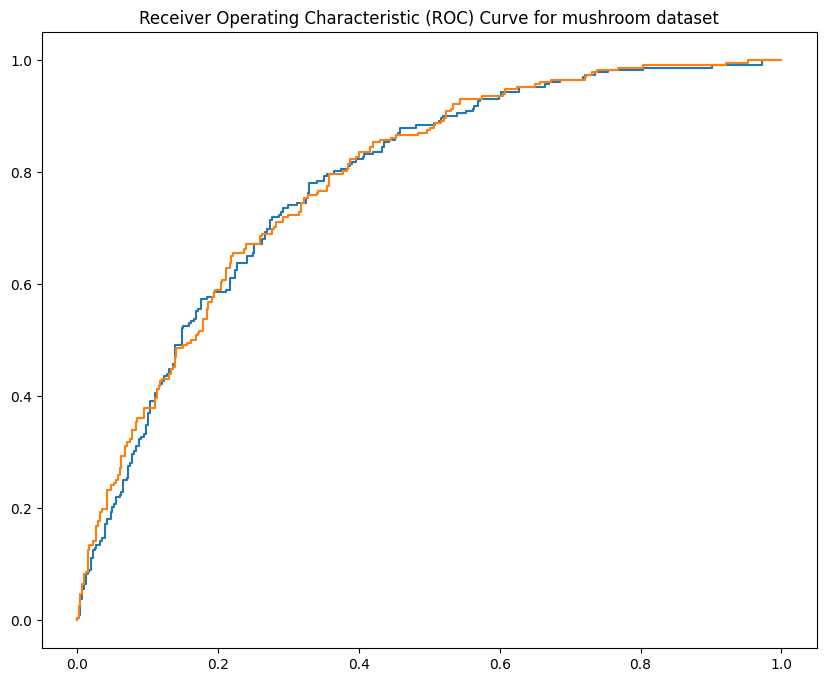

In [31]:
AUC_baseline, AUC_selftraining, AUC_cotraining = plotROC(
    models={
        "Baseline Model": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_FILENAME
        )),
        "Self Learning": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_SELFTRAIN_FILENAME
        )),
        "Co-Training": (model1, model2)
    },
    X_test=X_test,
    y_test=y_test,
    y_pred_proba=(model1.predict_proba(X_test_1), model2.predict_proba(X_test_2)),
    dataset="mushroom"
);
print("AUC of the baseline model: ", AUC_baseline);
print("AUC of the self-training model: ", AUC_selftraining);
print("AUC of the co-training model: ", AUC_cotraining);